In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import multivariate_normal
from scipy.stats import norm

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
all_data = pd.read_csv('owid-covid-data.csv',
                       parse_dates = ['date'], dayfirst = True)

In [3]:
all_data.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,...,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
3,ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
4,ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN


In [4]:
col = all_data.columns

ru_data = all_data.loc[(all_data['iso_code'] == 'RUS') & (all_data['date'] >= '2020-03-03')][col[2:5]]
ru_data['day_number'] = (ru_data['date'] - min(ru_data['date'])) / np.timedelta64(1, 'D')
ru_data['new_cases'] = ru_data['new_cases'] + 1
ru_data.head()

,date,total_cases,new_cases,day_number
13450,2020-03-03,3,2,0.0
13451,2020-03-04,4,2,1.0
13452,2020-03-05,4,1,2.0
13453,2020-03-06,4,1,3.0
13454,2020-03-07,10,7,4.0


In [5]:
train_data = ru_data[:60].reset_index(drop=True)
test_data = ru_data[60:].reset_index(drop=True)

date_train = np.array(train_data['date'])
total_train = np.array(train_data['total_cases'])
new_train = np.array(train_data['new_cases'])
day_train = np.array(train_data['day_number'])

date_test = np.array(test_data['date'])
total_test = np.array(test_data['total_cases'])
new_test = np.array(test_data['new_cases'])
day_test = np.array(test_data['day_number'])

date_all = np.array(ru_data['date'])
day_all = np.array(ru_data['day_number'])

In [6]:
def draw_train_test (train, test, ax, scatter = True):
    ax.set_xlim((day_all[0], day_all[-1] + 2))
    ax.legend()
    if scatter:
        ax.scatter(day_train, train, s = 50, label="train")
        ax.scatter(day_test, test, s = 50, label="test")
    else:
        ax.plot(day_train, train, label="train")
        ax.plot(day_test, test, label="test")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


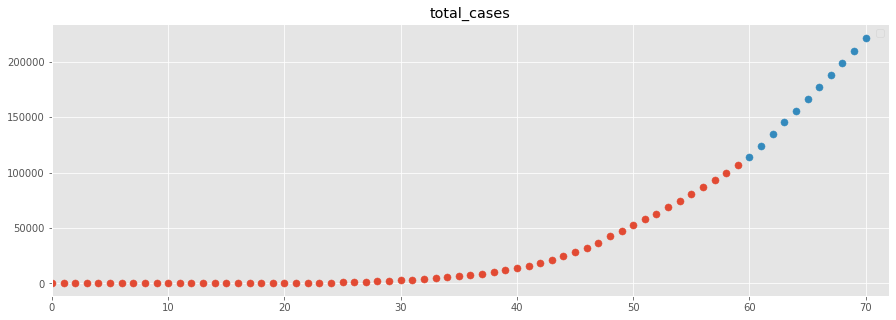

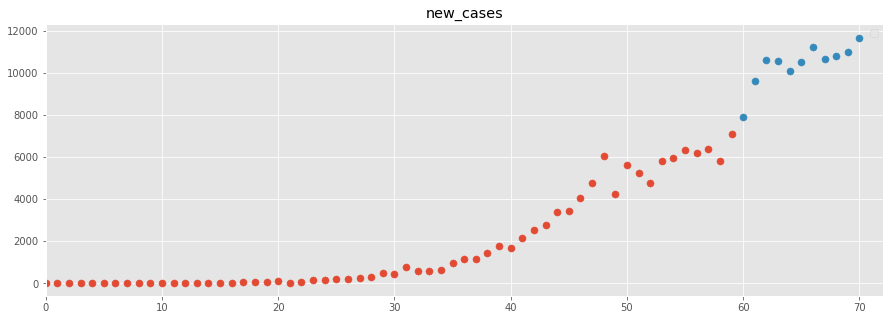

In [8]:
#Построим графики зависимостей целевых показателей от кол-ва дней

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('total_cases')
draw_train_test(total_train, total_test, ax)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('new_cases')
draw_train_test(new_train, new_test, ax)

plt.show()

# Задание 2

In [9]:
class ExpLinearRegression:
    def fit(self, x, y):
        X = x.reshape(-1,1)
        Y = np.log(y).reshape(-1,1)
        new_col = np.ones((X.shape[0], 1))
        X = np.append(X, new_col, 1)
        self.w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X) + (0 * np.eye(2))), X.T), Y)
        self.sigma_noise = np.std(np.dot(X, self.w) - Y)
        
    def predict(self, x):
        X = x.reshape(-1,1)
        new_col = np.ones((X.shape[0], 1))
        X = np.append(X, new_col, 1)
        return np.exp(np.dot(X, self.w))
    
    def get_sigma_noise(self):
        return self.sigma_noise

No handles with labels found to put in legend.
No handles with labels found to put in legend.


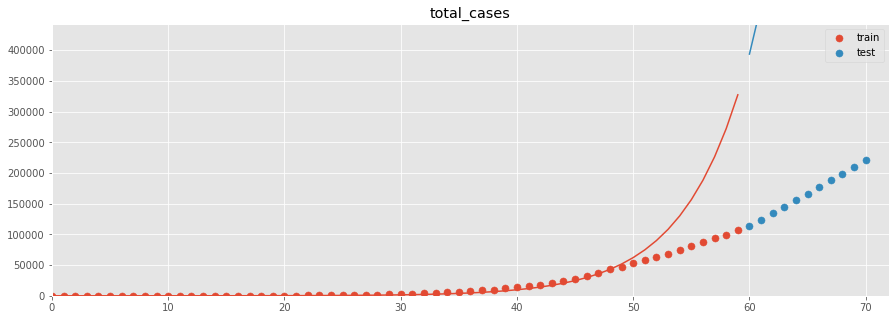

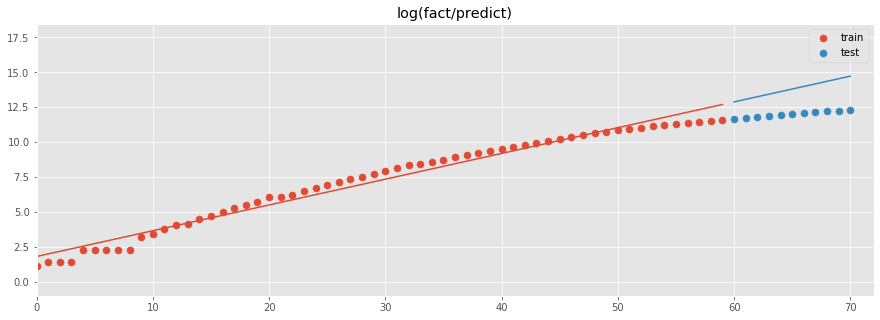

In [10]:
#Построим y ~ exp(линейная функция от x) и найдем сигму шума
model = ExpLinearRegression()
model.fit(day_train, total_train)
preds_train = model.predict(day_train)
preds_test = model.predict(day_test)

sigma_noise = model.get_sigma_noise()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('total_cases')
ax.set_ylim((-1, max(total_test) * 2))
draw_train_test(total_train, total_test, ax)
draw_train_test(preds_train, preds_test, ax, False)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('log(fact/predict)')
ax.set_ylim((-1, np.log(max(total_test)) * 1.5))
draw_train_test(np.log(total_train), np.log(total_test), ax)
draw_train_test(np.log(preds_train), np.log(preds_test), ax, False)

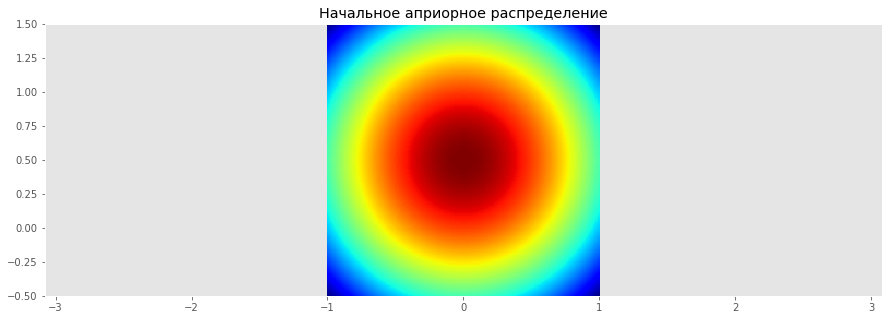

In [11]:
w_0 = np.linspace(-1, 1, 250)
w_1 = np.linspace(-0.5, 1.5, 250)
w_0, w_1 = np.meshgrid(w_0, w_1)

pos = np.empty(w_0.shape + (2,))
pos[:, :, 0] = w_0
pos[:, :, 1] = w_1

def myplot_heatmap(Z, ax):
    ax.axis('equal')
    ax.set_xlim((-1, 1))
    ax.set_ylim((-0.5, 1.5))
    ax.pcolormesh(w_0, w_1, Z, cmap=plt.cm.jet)
    

fig = plt.figure()
ax = fig.add_subplot(111)

#Задаем начальное априорное распределение 
#из графика видно, что угол наклона нашей прямой лежит в диапазоне от 0 до 1
cur_mu, cur_sigma = np.array([0, .5]), 2 * np.eye(2)
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
ax.set_title('Начальное априорное распределение')
myplot_heatmap(Z, ax)

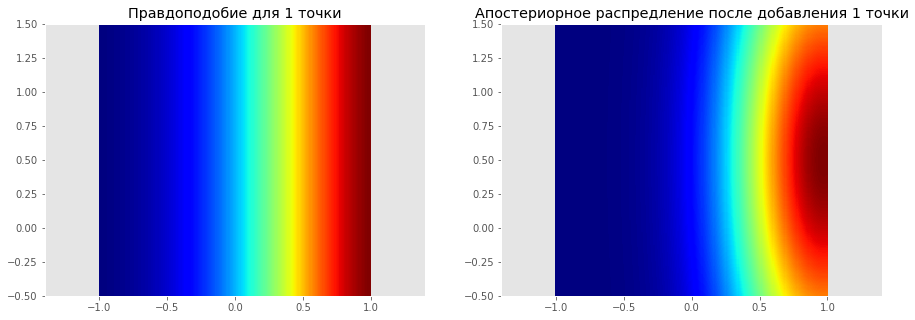

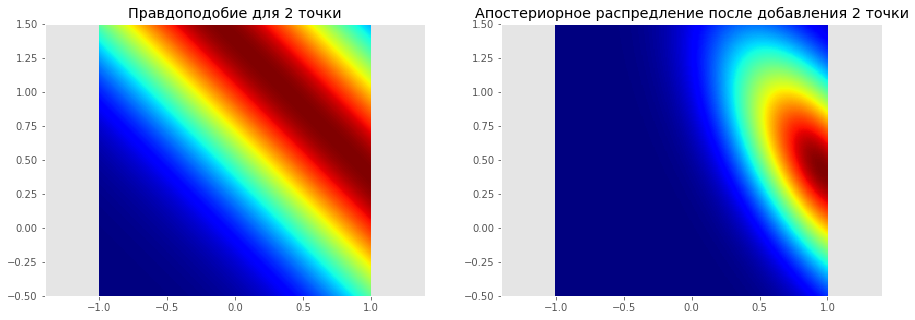

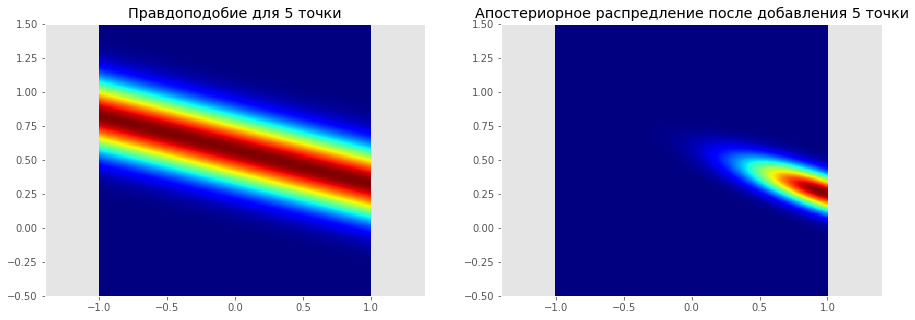

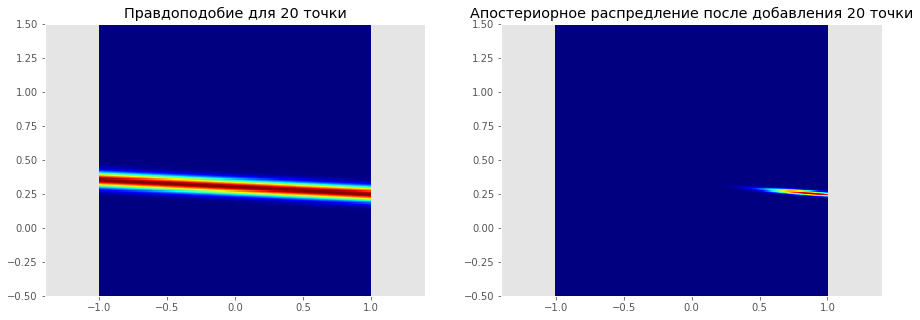

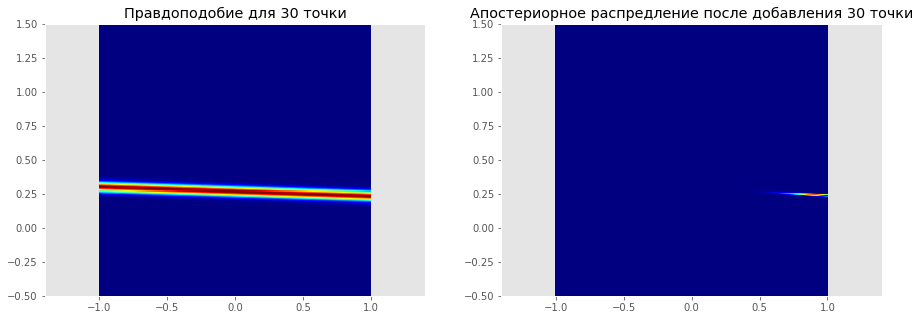

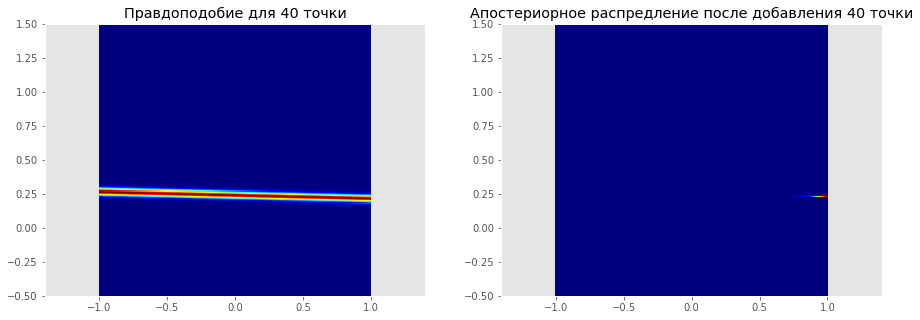

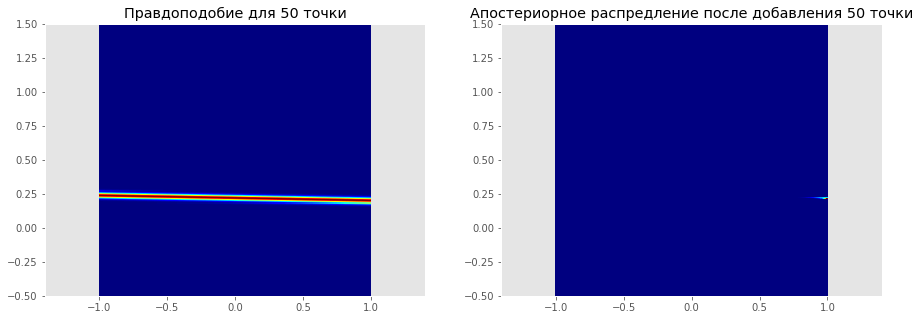

In [14]:
#Будем постепенно добавлять точки, пересчитывая mu и sigma
print_points = [0, 1, 4, 19, 29, 39, 49]
for index in range(day_train.shape[0]):
    px = day_train[index]
    py = np.log(total_train[index])

    x = np.array([[1, px]])
    post_sigma = np.linalg.inv(np.linalg.inv(cur_sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(x.T, x) )
    post_mu = np.dot(post_sigma, np.dot(np.linalg.inv(cur_sigma), np.transpose(cur_mu)) + (1 / (sigma_noise ** 2)) * np.dot(x.T, np.array([py]) ) )
    Z = multivariate_normal.pdf(pos, mean=post_mu, cov=post_sigma)

    if px in print_points:
        likelihood = np.array([[multivariate_normal.pdf(py, 
                                                        mean=np.dot([[1, px]], pos[i, j].reshape(-1,1)), 
                                                        cov=sigma_noise)
                                for j in range(pos.shape[1])] for i in range(pos.shape[0])])

        f, (ax1, ax2) = plt.subplots(1, 2)
        myplot_heatmap(likelihood, ax1)
        myplot_heatmap(Z, ax2)
        ax1.set_title("Правдоподобие для %.f точки" % (index + 1))
        ax2.set_title("Апостериорное распредление после добавления %.f точки" % (index + 1))

    cur_mu = post_mu
    cur_sigma = post_sigma

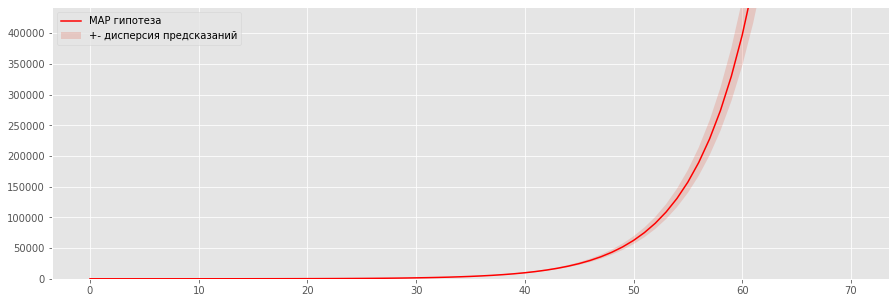

In [15]:
# Просемплируем экспоненты
my_w = np.random.multivariate_normal(cur_mu, cur_sigma, 2000)
res = np.zeros((2000, day_all.shape[0]))
for i, w in enumerate(my_w):
    res[i,:] = np.exp(w[0] + w[1] * day_all)

    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim((-1, max(total_test) * 2))
ax.plot(day_all, np.exp(cur_mu[1] * day_all + cur_mu[0]), color="red", label="MAP гипотеза")
ax.fill_between(day_all,(np.mean(res, axis=0) - np.std(res, axis=0)), 
                (np.mean(res, axis=0) + np.std(res, axis=0)), alpha=.2, label="+- дисперсия предсказаний")
plt.legend()

In [16]:
day = np.array(['2020-05-01', '2020-06-01',  '2020-09-01'], dtype='datetime64')
num_day = (day - np.datetime64('2020-03-03')) / np.timedelta64(1, 'D')

data = np.zeros((2000, 3))
for i, w in enumerate(my_w):
    data[i,:] = np.exp(w[0] + w[1] * num_day)

for i in range(3):
        mean = np.mean(data[:,i])
        std = np.std(data[:,i])
        print(day[i], '%.f - %.f' % (mean - std, mean + std))

2020-05-01 289253 - 375901
2020-06-01 79176499 - 129925169
2020-09-01 1040498184060613 - 4814029929135167


# Задание 3

No handles with labels found to put in legend.


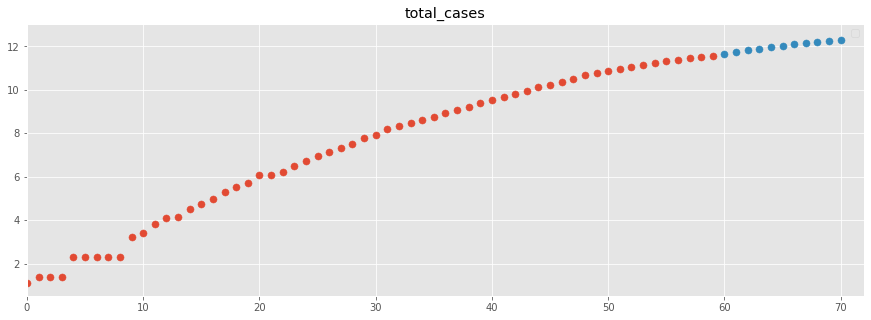

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('total_cases')
draw_train_test(np.log(total_train), np.log(total_test), ax)

plt.show()

In [20]:
class SigmoidLinearRegression:
    def fit(self, x, y):
        X = x.reshape(-1,1)
        X = np.append(X * X, X, 1)
        new_col = np.ones((X.shape[0], 1))
        X = np.append(X, new_col, 1)
        Y = np.log(y).reshape(-1,1)
        self.w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X) + (0 * np.eye(3))), X.T), Y)
        self.sigma_noise = np.std(np.dot(X, self.w) - Y)
        print(self.w)
        
    def predict(self, x):
        X = x.reshape(-1,1)
        X = np.append(X * X, X, 1)
        new_col = np.ones((X.shape[0], 1))
        X = np.append(X, new_col, 1)
        return np.exp(np.dot(X, self.w))
    
    def get_sigma_noise(self):
        return self.sigma_noise

No handles with labels found to put in legend.


[[-0.00182596]
 [ 0.27173671]
 [-0.54418044]]


(0, 150)

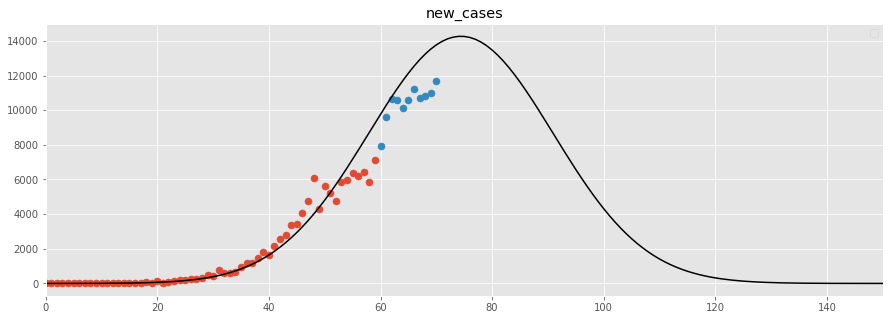

In [21]:
model = SigmoidLinearRegression()
model.fit(day_train, new_train)
preds_train = model.predict(day_train)
preds_test = model.predict(day_test)

sigma_noise = model.get_sigma_noise()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('new_cases')
draw_train_test(new_train, new_test, ax)
ax.plot(np.array(range(183)), model.predict(np.array(range(183))), color = 'black')
ax.set_xlim((0, 150))

In [22]:
w_0 = np.linspace(-2, 2, 250)
w_1 = np.linspace(-2, 2, 250)
w_2 = np.linspace(-2, 2, 250)
w_0, w_1, w_2 = np.meshgrid(w_0, w_1, w_2)

pos = np.empty(w_0.shape + (3,))
pos[:, :, :,0] = w_0
pos[:, :, :, 1] = w_1
pos[:, :, :, 2] = w_2 


#Задаем начальное априорное распределение 
cur_mu, cur_sigma = np.array([0, 0, 0]), 2 * np.eye(3)
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)

In [23]:
for index in range(day_train.shape[0]):
    px = day_train[index]
    py = np.log(new_train[index])

    x = np.array([[px ** 2, px, 1]])
    post_sigma = np.linalg.inv(np.linalg.inv(cur_sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(x.T, x) )
    post_mu = np.dot(post_sigma, np.dot(np.linalg.inv(cur_sigma), np.transpose(cur_mu)) + (1 / (sigma_noise ** 2)) * np.dot(x.T, np.array([py])))    
    cur_mu = post_mu
    cur_sigma = post_sigma

In [24]:
max_day = int((np.datetime64('2020-09-01') - np.datetime64('2020-03-03')) / np.timedelta64(1, 'D'))

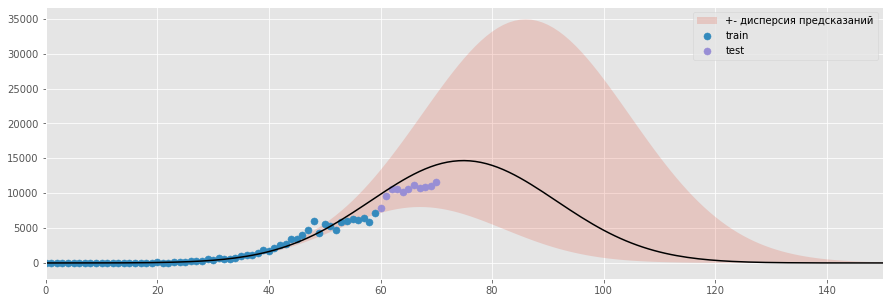

In [61]:
my_w = np.random.multivariate_normal(cur_mu, cur_sigma, 2000)
x_all = np.array(range(250))

x_all = x_all.reshape(-1,1)
x_all = np.append(x_all * x_all, x_all, 1)
new_col = np.ones((250, 1))
x_all = np.append(x_all, new_col, 1)
        
res = np.zeros((2000, 250))
for i, w in enumerate(my_w):
    res[i,:] = np.dot(x_all, w)

    
fig = plt.figure()
ax = fig.add_subplot(111)
res_new = np.exp(np.dot(x_all, cur_mu))
ax.plot(np.array(range(250)), res_new, color = 'black')
ax.fill_between(np.array(range(250)), np.exp(np.mean(res, axis=0) - np.std(res, axis=0)), 
                np.exp(np.mean(res, axis=0) + np.std(res, axis=0)), alpha=.2, label="+- дисперсия предсказаний")
draw_train_test(new_train, new_test, ax)
ax.set_xlim((0,150))
plt.legend()

In [62]:
for i in range(3):
        print("%.f"%sum(res_new[:int(num_day[i])]))

99582
495973
611996


In [76]:
res_total = np.zeros(c)
res_total[0] = res_new[0]
for i in range(249):
    res_total[i + 1] = res_total[i] + res_new[i + 1]

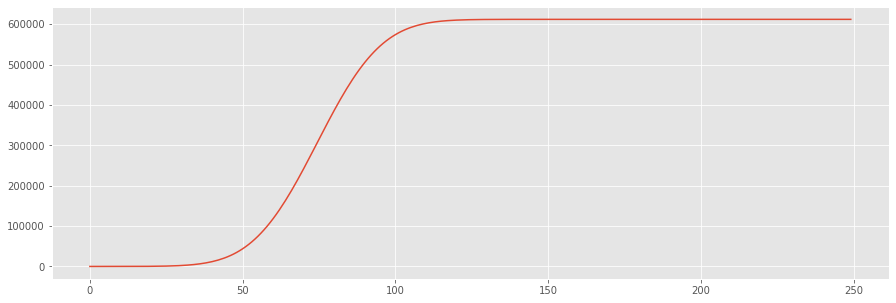

In [85]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(250), res_total)